# **ORDER DAYS PREDICTION**

## DATA SCIENCE

### 1. Problem Definition

The logistics department needs to improve our delivery system by smartly **allocating delivery resources.** 

#### 1.1 Problem to be Solved
Predict the number of order days in the month for each user, it is needed to be able to perform this prediction at every point of the month.

**Since our output should be the number of order days, we can state that this is a regression problem**.

 With this, there are some algorithms that could be more usefull, such as: linear regression, XGBRegression, SVR, etc. In addition, metrics like MAE, MSE, RMSE, etc. should be used. BUT, the main metric **we'll be using to evaluate the model is going to be the MAE (Mean Absolute Error)**, the reason for this is MAE measures the mean error in real unities and, with this, we could check how many missing days we are making in a month, in addition it doesn't penalizes extreme errors (outliers) like RMSE. RMSE could also be used depending in our results of our historical dataset regarding outliers.
 
All this informations will be confirmed through the analysis.

#### 1.2 Objectives
The main objective of this project is to:
  * Forecast the number of order days
  * Allow real time prediction


### 2. Exploratory Data Analysis (EDA) - *Part 1*

In this first part of the EDA, we'll understand the current data structure of our datasets.

In [8]:
# Data Manipulation
import pandas as pd
import numpy as np
import itertools

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Statistics
import statsmodels.api as sm
from statsmodels import *
from scipy.stats import *
import math
from scikit_posthocs import posthoc_dunn

# Warnings
import warnings
warnings.filterwarnings('ignore')

#### 2.1 Data Collection
First, let's collect our data that are stored in `parquet`.

In [13]:
# Importing DataFrames
historical_orders_df = pd.read_parquet(r"D:\Bruno Serra PC\Documents\Bruno\Visual Studio\AB Inbev - Data Test\historical_orders.parquet", engine='pyarrow')
august_total_sales_df = pd.read_parquet(r"D:\Bruno Serra PC\Documents\Bruno\Visual Studio\AB Inbev - Data Test\august_total_sales.parquet", engine='pyarrow')
august_missing_order_days_df = pd.read_parquet(r"D:\Bruno Serra PC\Documents\Bruno\Visual Studio\AB Inbev - Data Test\august_with_missing_order_days.parquet", engine='pyarrow')

The `historical_orders` will be used as the test sample for our model, the `august_total_sales` for input data and **`august_with_missing_order_days` as an extra feature, combined with our model.**

It is also important to point out that the august_with_missing_order_days should be similuar to our test sample.

#### 2.2 Data Structure

##### 2.2.1 Shape

In [3]:
# Lists for each Dataframe
datasets = [august_missing_order_days_df, historical_orders_df, august_total_sales_df]
datasets_names = ['august_missing_order_days_df', 'historical_orders_df', 'august_total_sales_df']

# Iterating and printing the shapes (dimensions)
for i, table in enumerate(datasets, start = 0):
    print(f"{datasets_names[i]} - Shape: {table.shape}")

august_missing_order_days_df - Shape: (317735, 3)
historical_orders_df - Shape: (8596877, 3)
august_total_sales_df - Shape: (32944, 2)


##### 2.2.2 Data Type

In [4]:
# Itarating the previous lists for types
for i, table in enumerate(datasets, start=0):
    print(f"Dataset {i+1}: {datasets_names[i]}")
    print(table.dtypes)
    print()

Dataset 1: august_missing_order_days_df
account_id             object
order_date             object
transaction_amount    float64
dtype: object

Dataset 2: historical_orders_df
account_id             object
order_date             object
transaction_amount    float64
dtype: object

Dataset 3: august_total_sales_df
account_id                          object
total_transaction_amount_august    float64
dtype: object



According to the data types, we'll need to transform our order_date to `Date Time`.

##### 2.2.3 Outlier Identification

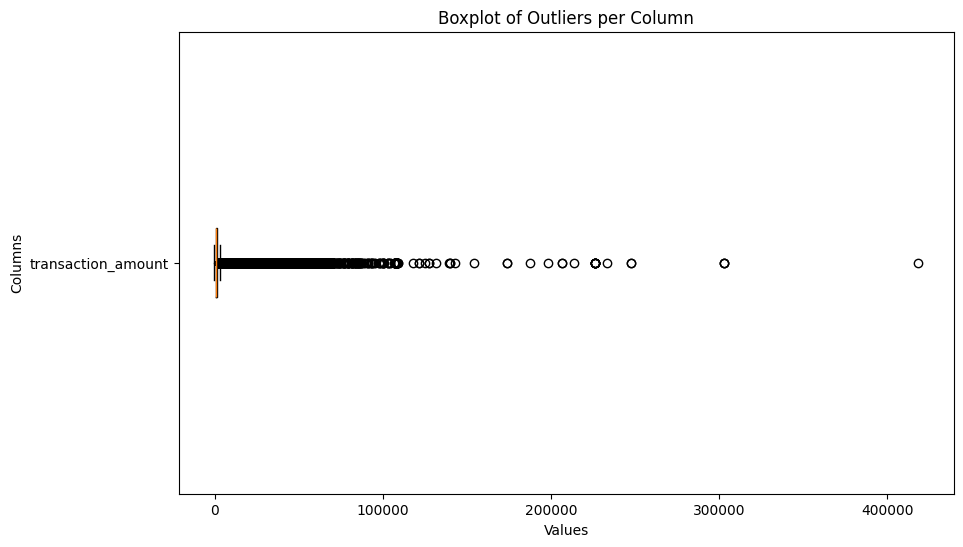

In [5]:
# Select only columns of type float64 or int64
numeric_cols = historical_orders_df.select_dtypes(include=['float64', 'int64'])

# Prepare a list to store outliers for each column
outliers_list = []

# Iterate over the numeric columns
for col in numeric_cols.columns:
    # Calculate the IQR of the column
    Q1 = numeric_cols[col].quantile(0.25)
    Q3 = numeric_cols[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = numeric_cols[(numeric_cols[col] < lower_bound) | (numeric_cols[col] > upper_bound)]

    # Add the values of the outliers found to the list
    outliers_list.append(outliers[col].values)

# Plot boxplots for each column with outliers
plt.figure(figsize=(10, 6))
plt.boxplot(outliers_list, labels=numeric_cols.columns, vert=False)
plt.title('Boxplot of Outliers per Column')
plt.xlabel('Values')
plt.ylabel('Columns')
plt.show()

##### 2.2.4 Number of Unique Users

In [6]:
# Count Unique Users
for index, df in enumerate(datasets):
    count_unique_users = df['account_id'].nunique()
    
    # Print 
    print(f"The number of unique account IDs in {datasets_names[index]} is {count_unique_users}")

The number of unique account IDs in august_missing_order_days_df is 32944
The number of unique account IDs in historical_orders_df is 47899
The number of unique account IDs in august_total_sales_df is 32944


The unique users from the three datasets is different, but, according to our statement, we must consider all users. So, we'll consider the 47899 users available in `historical_orders_df`.

##### 2.2.5 Null, Nans and Zeros

In [7]:
for index, df in enumerate(datasets):
    null_counts = df.isnull().sum()
    
    # Check result
    print(f"Null counts in dataset {datasets_names[index]}:")
    print(null_counts)
    print("\n") 

Null counts in dataset august_missing_order_days_df:
account_id                0
order_date            13438
transaction_amount    13438
dtype: int64


Null counts in dataset historical_orders_df:
account_id            0
order_date            0
transaction_amount    0
dtype: int64


Null counts in dataset august_total_sales_df:
account_id                         0
total_transaction_amount_august    0
dtype: int64




There is no nulls in our historical and august sales datasets, only in our missing orders, which was already expected.

#### 2.3 Descriptive Statistics

##### 2.3.1 First and Last Rows
First let's go for the first rows.

In [8]:
for index, dataset in enumerate(datasets):
    print(f"First few rows of dataset '{datasets_names[index]}':")
    display(dataset.head())
    print("\n") 

First few rows of dataset 'august_missing_order_days_df':


,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52
2,BR_09532176632,2022-08-03,24.90
3,BR_09532176632,2022-08-03,28.50
4,BR_09532176632,2022-08-03,11.16




First few rows of dataset 'historical_orders_df':


,account_id,order_date,transaction_amount
0,BR_09607801000194,2021-08-28,11011.2
1,BR_09607801000194,2021-08-28,13764.0
2,BR_09607801000194,2021-08-28,11011.2
3,BR_09607801000194,2021-08-28,11011.2
4,BR_09607801000194,2021-08-28,13764.0




First few rows of dataset 'august_total_sales_df':


,account_id,total_transaction_amount_august
0,BR_00000343803,309.99
1,BR_00001415930,874.98
2,BR_00001760106,11976.70
3,BR_00002485176,511.48
4,BR_00002536340,7081.14


Now, let's go for the last rows.

In [9]:
for index, dataset in enumerate(datasets):
    print(f"Last few rows of dataset '{datasets_names[index]}':")
    display(dataset.tail())
    print("\n") 

Last few rows of dataset 'august_missing_order_days_df':


,account_id,order_date,transaction_amount
317730,BR_30398656000175,None,NaN
317731,BR_01248390377,None,NaN
317732,BR_03803067863,None,NaN
317733,BR_49558358487,None,NaN
317734,BR_82856567649,None,NaN




Last few rows of dataset 'historical_orders_df':


,account_id,order_date,transaction_amount
9397109,BR_07543270000198,2022-04-07,463.0
9397110,BR_11366636000178,2022-04-07,378.0
9397111,BR_80376890000170,2022-04-07,448.2
9397112,BR_09010853403,2022-04-07,407.4
9397113,BR_07309527000141,2022-04-06,1048.5




Last few rows of dataset 'august_total_sales_df':


,account_id,total_transaction_amount_august
32939,BR_99904403791,2996.69
32940,BR_99910241587,4225.98
32941,BR_99936259300,646.44
32942,BR_99946866587,494.36
32943,BR_99959577104,87.80


##### 2.3.2 General Statistics

In [10]:
# General statistics
for index, dataset in enumerate(datasets):
    print(f"{datasets_names[index]}:")
    display(dataset.describe())

august_missing_order_days_df:


,transaction_amount
count,304297.000000
mean,281.339536
std,1251.632794
min,-99.000000
25%,34.930000
50%,84.000000
75%,205.250000
max,171325.440000


historical_orders_df:


,transaction_amount
count,8.596877e+06
mean,2.755161e+02
std,1.269133e+03
min,-6.075000e+02
25%,3.294000e+01
50%,8.070000e+01
75%,1.964400e+02
max,4.185789e+05


august_total_sales_df:


,total_transaction_amount_august
count,3.294400e+04
mean,6.413068e+03
std,3.953953e+04
min,-9.108000e+03
25%,5.700300e+02
50%,1.638605e+03
75%,4.558312e+03
max,2.638720e+06


According to our first part of EDA, we'll already could assume some next steps for the pre processing:

    - Transform the attributes to the proper data types
    - Create two new attributes for year and month
    - Group the users in order to find the orders days (quantity of order days per user per month)
    - Perform a crossjoin with the dates with account_id in order to have all users in all months (it is important to measure when a user did not have any order day)
    - Create possible attributes in order to improve the model prediction

### 3. Pre Processing

In this session we'll perform the pre processing of our dataset according to the first part of the EDA.

#### 3.1 Data Type Transforming
In the first pre processing, let's transform our data to the correct format.

In [11]:
# Copy
historical_orders_dated_df = historical_orders_df.copy()

# Converting the data attributes
historical_orders_dated_df['order_date'] = pd.to_datetime(historical_orders_dated_df['order_date'])

# Print
historical_orders_dated_df.head()

,account_id,order_date,transaction_amount
0,BR_09607801000194,2021-08-28,11011.2
1,BR_09607801000194,2021-08-28,13764.0
2,BR_09607801000194,2021-08-28,11011.2
3,BR_09607801000194,2021-08-28,11011.2
4,BR_09607801000194,2021-08-28,13764.0


#### 3.2 Grouping in Order Days
In order to have the same format as our output, we'll create a new column with the quantity of order days per month per user.

In [12]:
# Copy
historical_grouped_df = historical_orders_dated_df.copy()

# Grouping by account_id and order_date
historical_grouped_df = historical_grouped_df.groupby(['account_id', 'order_date']).agg(transaction_amount = ('transaction_amount', 'sum')).reset_index()
historical_grouped_df['month_year'] = historical_grouped_df['order_date'].dt.to_period('M')
historical_grouped_df = historical_grouped_df.groupby(['account_id', 'month_year']).agg(transaction_amount=('transaction_amount', 'sum'), order_days=('transaction_amount', 'count')).reset_index()

# Print
historical_grouped_df.head()

,account_id,month_year,transaction_amount,order_days
0,BR_00000343803,2021-01,814.92,4
1,BR_00000343803,2021-02,484.76,2
2,BR_00000343803,2021-03,661.68,3
3,BR_00000343803,2021-04,575.08,1
4,BR_00000343803,2021-05,859.12,3


#### 3.3 Cross Join in Test Sample
Create a new column with the quantity of order days per month per user. We'll **create a new dataset with all users in the `historical_data` in every month, but, for the users that didn't buy, we'll fill the values with 0 for transaction_amount and order_days.**

In [13]:
# Creating an array with all accounts and months
all_accounts = historical_grouped_df['account_id'].unique()
all_months = historical_grouped_df['month_year'].unique()

# Print number of accounts / users
print(f" The number of accounts is {historical_grouped_df['account_id'].nunique()}.")

 The number of accounts is 47899.


Now, let's perform the cartesian product between the two arrays and fill with 0 in the users that didn't buy in a month (in order to don't have NaNs).

In [14]:
# Creating a combination with all accounts and months
all_combinations = pd.MultiIndex.from_product([all_accounts, all_months], names=['account_id', 'month_year']).to_frame(index=False)

# Left join the historical_grouped_df with the all_combinations dataframe
historical_orders_crossed = all_combinations.merge(historical_grouped_df, on=['account_id', 'month_year'], how='left')

# Filling the NaNs with 0
historical_orders_crossed['transaction_amount'] = historical_orders_crossed['transaction_amount'].fillna(0)
historical_orders_crossed['order_days'] = historical_orders_crossed['order_days'].fillna(0).astype(int)

# Print
historical_orders_crossed.head(5)

,account_id,month_year,transaction_amount,order_days
0,BR_00000343803,2021-01,814.92,4
1,BR_00000343803,2021-02,484.76,2
2,BR_00000343803,2021-03,661.68,3
3,BR_00000343803,2021-04,575.08,1
4,BR_00000343803,2021-05,859.12,3


Performing a quick Q.A. (Quality Assurance) in order to check if the values are correct. For this, we'll sum the transaction_amount and order_days. If both values are the same, the dataset is correct.a


In [15]:
# Summing values
total_transaction_original = np.sum(historical_orders_df['transaction_amount']).round(2)
total_order_days_original = np.sum(historical_grouped_df['order_days']).round(2)
total_transaction_new = np.sum(historical_orders_crossed['transaction_amount']).round(2)
total_order_days_new = np.sum(historical_orders_crossed['order_days']).round(2)

# Print
print("Original Dataframe")
print(f"Total transaction: {total_transaction_original}")
print(f"Total order days: {total_order_days_original}")
print("\n")
print("New Dataframe")
print(f"Total transaction: {total_transaction_new}")
print(f"Total order days: {total_order_days_new}")

# Check if the totals are the same
if (total_transaction_original == total_transaction_new) and (total_order_days_original == total_order_days_new):
    print("\nThe totals are the same for both DataFrames.")
else:
    print("\nThe totals differ between the original and new DataFrames.")

Original Dataframe
Total transaction: 2368577736.03
Total order days: 1428384


New Dataframe
Total transaction: 2368577736.03
Total order days: 1428384

The totals are the same for both DataFrames.


#### 3.4 Splitting Date Attribute
**For now, we have one account_id for each month, if the user didn't buy, we placed 0**. The next step is to create columns with month and year.

In [16]:
# Copy
historical_orders_date_splitted = historical_orders_crossed.copy()

# Creating columns
historical_orders_date_splitted['year'] = historical_orders_date_splitted['month_year'].dt.year
historical_orders_date_splitted['month'] = historical_orders_date_splitted['month_year'].dt.month

# Reordering
historical_orders_date_splitted = historical_orders_date_splitted[['account_id', 'month_year', 'year', 'month', 'order_days', 'transaction_amount']]

# Print
historical_orders_date_splitted.head()

,account_id,month_year,year,month,order_days,transaction_amount
0,BR_00000343803,2021-01,2021,1,4,814.92
1,BR_00000343803,2021-02,2021,2,2,484.76
2,BR_00000343803,2021-03,2021,3,3,661.68
3,BR_00000343803,2021-04,2021,4,1,575.08
4,BR_00000343803,2021-05,2021,5,3,859.12


#### 3.5 Cumulative Average


In order to improve our model, we'll create a cumulative average for each user thourgh the months.

In [17]:
# Copy
historical_oders_moving_average = historical_orders_date_splitted.copy()

# Cumulative Average
historical_oders_moving_average['cumulative_mean_per_transaction_amount'] = (
    historical_oders_moving_average
    .groupby('account_id')['transaction_amount']
    .transform(lambda x: x.expanding(min_periods=1).mean())
)

# Print
historical_oders_moving_average.head()

,account_id,month_year,year,month,order_days,transaction_amount,cumulative_mean_per_transaction_amount
0,BR_00000343803,2021-01,2021,1,4,814.92,814.920000
1,BR_00000343803,2021-02,2021,2,2,484.76,649.840000
2,BR_00000343803,2021-03,2021,3,3,661.68,653.786667
3,BR_00000343803,2021-04,2021,4,1,575.08,634.110000
4,BR_00000343803,2021-05,2021,5,3,859.12,679.112000


#### 3.6 Months with no Order Days


We'll create an extra attribue with the quantity of months without order days for each user per month, in order to understand the patterns of users (lag between "buy" months).

In [18]:
historical_orders_orders_lag = historical_oders_moving_average.copy()

# Função para calcular os meses sem compras
def count_months_without_purchases(transaction_amount_series):
    count = 0
    no_purchase_months = []
    for transaction_amount in transaction_amount_series:
        if transaction_amount == 0:
            count += 1
        else:
            count = 0
        no_purchase_months.append(count)
    return no_purchase_months

# Aplicando a função para cada `account_id`
historical_orders_orders_lag['months_without_purchase'] = (
    historical_orders_orders_lag
    .groupby('account_id')['transaction_amount']
    .transform(count_months_without_purchases)
)

historical_orders_orders_lag.head()


,account_id,month_year,year,month,order_days,transaction_amount,cumulative_mean_per_transaction_amount,months_without_purchase
0,BR_00000343803,2021-01,2021,1,4,814.92,814.920000,0
1,BR_00000343803,2021-02,2021,2,2,484.76,649.840000,0
2,BR_00000343803,2021-03,2021,3,3,661.68,653.786667,0
3,BR_00000343803,2021-04,2021,4,1,575.08,634.110000,0
4,BR_00000343803,2021-05,2021,5,3,859.12,679.112000,0


#### 3.7 LAG Attributes
Since we have dates, we should create LAGs in order to use the LAGs as features in our model (since usually there' a correlation between a value with the its previous).

NOTE: It's really important to group by account_id and order_days since we need the LAG for each user. If we don't do this, we'll have wrong LAGs.

In [19]:
# Copy
historical_full_df = historical_orders_orders_lag.copy()

# Creating LAGs
historical_full_df['order_days_lag_1'] = (historical_full_df.groupby('account_id')['order_days'].shift(1))
historical_full_df['order_days_lag_2'] = (historical_full_df.groupby('account_id')['order_days'].shift(2))
historical_full_df['order_days_lag_3'] = (historical_full_df.groupby('account_id')['order_days'].shift(3))
historical_full_df['order_days_lag_4'] = (historical_full_df.groupby('account_id')['order_days'].shift(4))
historical_full_df['order_days_lag_5'] = (historical_full_df.groupby('account_id')['order_days'].shift(5))
historical_full_df['order_days_lag_6'] = (historical_full_df.groupby('account_id')['order_days'].shift(6))

# Dropping NaNs
historical_full_df = historical_full_df.dropna()

# Print
historical_full_df.head()

,account_id,month_year,year,month,order_days,transaction_amount,cumulative_mean_per_transaction_amount,months_without_purchase,order_days_lag_1,order_days_lag_2,order_days_lag_3,order_days_lag_4,order_days_lag_5,order_days_lag_6
6,BR_00000343803,2021-07,2021,7,2,431.90,614.614286,0,2.0,3.0,1.0,3.0,2.0,4.0
7,BR_00000343803,2021-08,2021,8,2,670.68,621.622500,0,2.0,2.0,3.0,1.0,3.0,2.0
8,BR_00000343803,2021-09,2021,9,3,458.68,603.517778,0,2.0,2.0,2.0,3.0,1.0,3.0
9,BR_00000343803,2021-10,2021,10,2,932.18,636.384000,0,3.0,2.0,2.0,2.0,3.0,1.0
10,BR_00000343803,2021-11,2021,11,3,1174.76,685.327273,0,2.0,3.0,2.0,2.0,2.0,3.0


### 4. Exploratory Data Analysis (EDA) - *Part 2*

Here, we'll perform a second EDA after the pre processing to understand our new data.

#### 4.1 General Statistics

In [248]:
historical_full_df.describe()

,year,month,order_days,transaction_amount,cumulative_mean_per_transaction_amount,months_without_purchase,order_days_lag_1,order_days_lag_2,order_days_lag_3,order_days_lag_4,order_days_lag_5,order_days_lag_6
count,622687.000000,622687.000000,622687.000000,6.226870e+05,6.226870e+05,622687.000000,622687.000000,622687.000000,622687.000000,622687.000000,622687.000000,622687.000000
mean,2021.538462,6.538462,1.747905,2.946061e+03,2.239022e+03,3.287308,1.681254,1.607947,1.524845,1.439407,1.337804,1.346614
std,0.498519,3.319303,2.326948,2.842965e+04,2.249714e+04,4.515816,2.317154,2.301575,2.283252,2.259257,2.198144,2.227750
min,2021.000000,1.000000,0.000000,-8.910000e+03,-7.659474e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021.000000,4.000000,0.000000,0.000000e+00,1.424878e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2022.000000,7.000000,1.000000,5.580000e+01,2.074133e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2022.000000,9.000000,3.000000,1.490275e+03,1.085309e+03,7.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000
max,2022.000000,12.000000,26.000000,6.322759e+06,2.598620e+06,19.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000


According to the general statitics, the mean is 1.57 and the median is 0... also, the max value is 26. This could mean outliers that might prejudice our model.

#### 4.2 Check Dates

In [249]:
# Obtaining the minimum and maximum dates from the order_date column
# Historical orders
min_date_historical = historical_full_df['month_year'].min()
max_date_historical = historical_full_df['month_year'].max()

# Displaying the results
print("Historical dataset:")
print(f"The minimum date: {min_date_historical}")
print(f"The maximum date: {max_date_historical}")

Historical dataset:
The minimum date: 2021-07
The maximum date: 2022-07


The minimum date is now lower because of the dropped columns with NaNs from LAGs.

#### 4.3 Outlier
Let's plot out `order_days` per month in a boxplot to check outliers and the median, mean, etc.

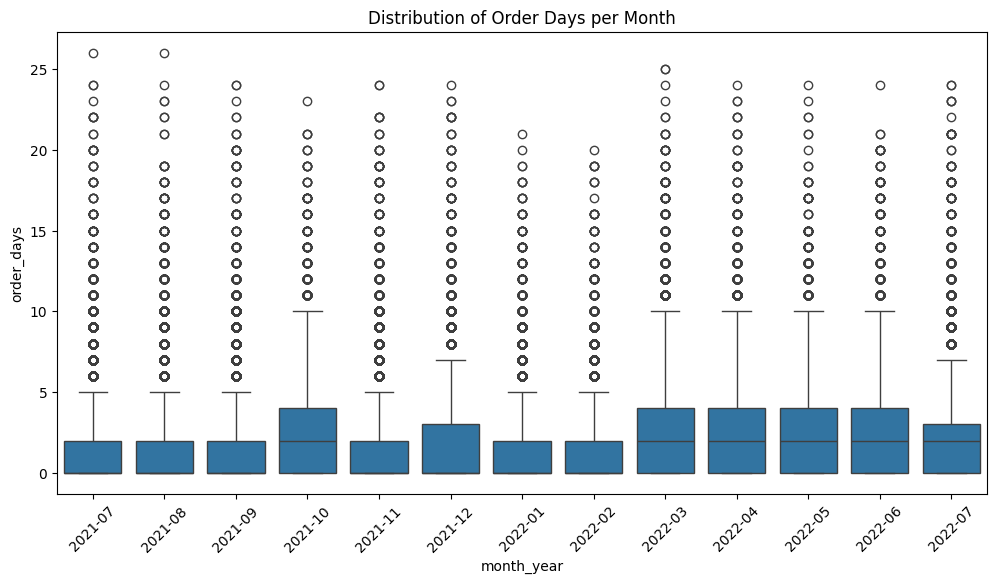

In [250]:
# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=historical_full_df, x='month_year', y='order_days')
plt.title('Distribution of Order Days per Month')
plt.xticks(rotation=45) 
plt.show()

**As we can see, the median is the same from 2022-03 until 2022-07!** Let's dive in the values, and also, check the mean.

In [251]:
# Calculating the mean and median per month
order_days_stats = historical_full_df.groupby('month_year')['order_days'].agg(
    mean_order_days='mean',
    median_order_days='median'
).round(0)  # Rounding the mean

# Printing the resulting DataFrame
display(order_days_stats)

,mean_order_days,median_order_days
month_year,,
2021-07,1.0,0.0
2021-08,1.0,0.0
2021-09,1.0,0.0
2021-10,2.0,2.0
2021-11,1.0,0.0
2021-12,1.0,0.0
2022-01,1.0,0.0
2022-02,1.0,0.0
2022-03,3.0,2.0


According to the data above, **we can see patterns in the past months regarding order days.**

Let's have a look in our outliers.

In [252]:
# Calculating Q1 and Q3 for `order_days`
Q1 = historical_full_df['order_days'].quantile(0.25)
Q3 = historical_full_df['order_days'].quantile(0.75)
IQR = Q3 - Q1

# Defining the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the values that were considered outliers
historical_outliers = historical_full_df[(historical_full_df['order_days'] < lower_bound) | 
                                      (historical_full_df['order_days'] > upper_bound)]

# Renaming columns
historical_outliers['order_days_outliers'] = historical_outliers['order_days']
historical_outliers = historical_outliers.drop(columns = 'order_days')

# Print
print("Outliers (IQR method):")
historical_outliers.head(10)

Outliers (IQR method):


,account_id,month_year,year,month,transaction_amount,cumulative_mean_per_transaction_amount,months_without_purchase,order_days_lag_1,order_days_lag_2,order_days_lag_3,order_days_lag_4,order_days_lag_5,order_days_lag_6,order_days_outliers
162,BR_00005396352,2021-11,2021,11,11150.87,18871.075455,0,7.0,7.0,6.0,2.0,7.0,8.0,8
163,BR_00005396352,2021-12,2021,12,19194.54,18898.030833,0,8.0,7.0,7.0,6.0,2.0,7.0,8
348,BR_00014989670,2021-07,2021,7,23291.19,22363.671429,0,9.0,10.0,10.0,10.0,10.0,12.0,12
349,BR_00014989670,2021-08,2021,8,17854.80,21800.062500,0,12.0,9.0,10.0,10.0,10.0,10.0,8
350,BR_00014989670,2021-09,2021,9,21250.34,21738.982222,0,8.0,12.0,9.0,10.0,10.0,10.0,11
351,BR_00014989670,2021-10,2021,10,18962.67,21461.351000,0,11.0,8.0,12.0,9.0,10.0,10.0,10
352,BR_00014989670,2021-11,2021,11,14345.40,20814.446364,0,10.0,11.0,8.0,12.0,9.0,10.0,10
353,BR_00014989670,2021-12,2021,12,19228.46,20682.280833,0,10.0,10.0,11.0,8.0,12.0,9.0,8
354,BR_00014989670,2022-01,2022,1,20539.88,20671.326923,0,8.0,10.0,10.0,11.0,8.0,12.0,9
355,BR_00014989670,2022-02,2022,2,27800.03,21180.520000,0,9.0,8.0,10.0,10.0,11.0,8.0,9


**Here's an important fact: the outliers that we found mostly continue beeing outliers in the past months.**

Let's check the accounts that has outliers.

In [253]:
# Accounts from outliers
outlier_account_ids = historical_outliers['account_id'].nunique()

# Print
print(f" The number of accounts in the outliers is {outlier_account_ids}.")

 The number of accounts in the outliers is 5290.


The total accounts is 47899.

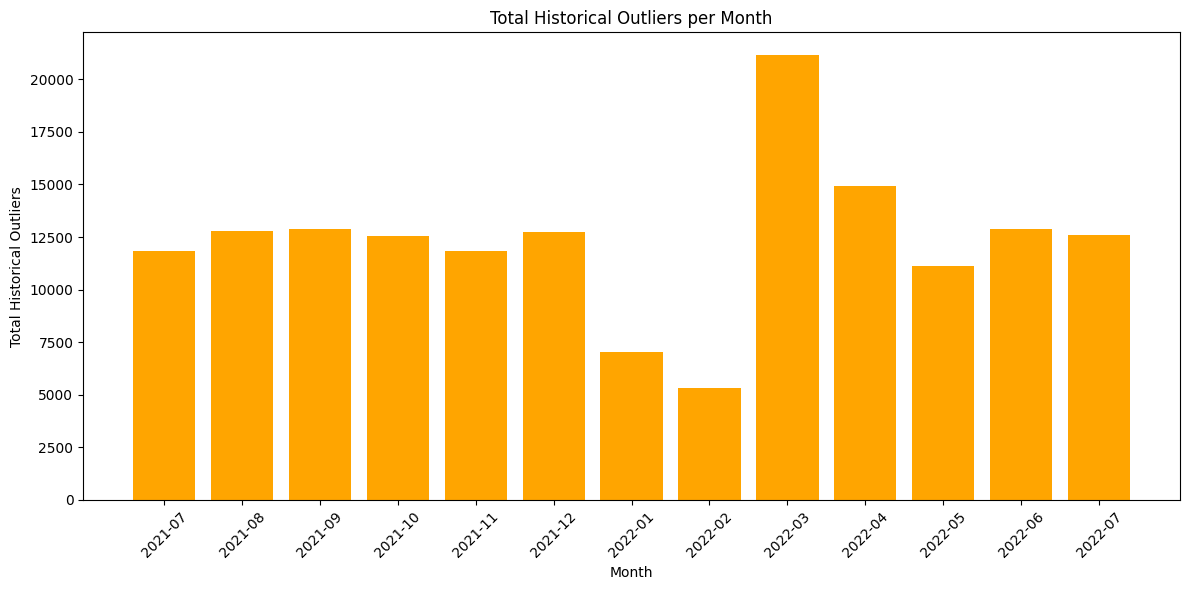

In [254]:
# Grouping and summing
grouped_data = historical_outliers.groupby('month_year')['order_days_outliers'].sum().reset_index()

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(grouped_data['month_year'].astype(str), grouped_data['order_days_outliers'], color='orange')
plt.xlabel('Month')
plt.ylabel('Total Historical Outliers')
plt.title('Total Historical Outliers per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

According to our bar chart above of our outliers, 2022-03 has the biggest incident of outliers.

#### 4.4 Distribution

Now, let's check the distribution of our target.

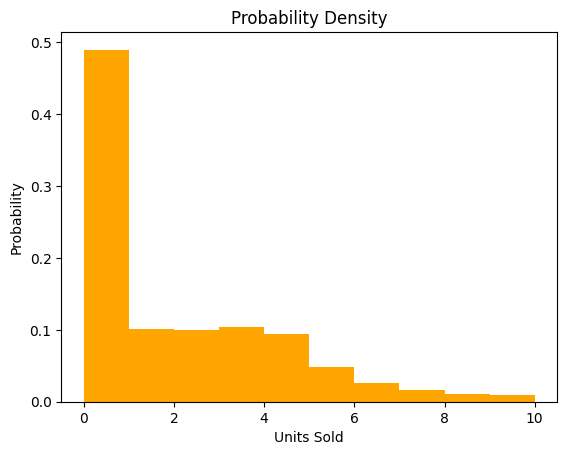

In [421]:
# Histogram
plt.hist(historical_full_df['order_days'], bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density = True, color = 'orange')
plt.xlabel('Units Sold')
plt.ylabel('Probability')
plt.title('Probability Density')
plt.show()

According to what we have, the distribution looks like to a **POISSON DISTRIBUTION**. The reason for this is: the order_days is a discrete variable of couting, it's in a fixed interval of time. Here we are measuring the probability of an user buy "x" times in the next month.

#### 4.5 Time Series

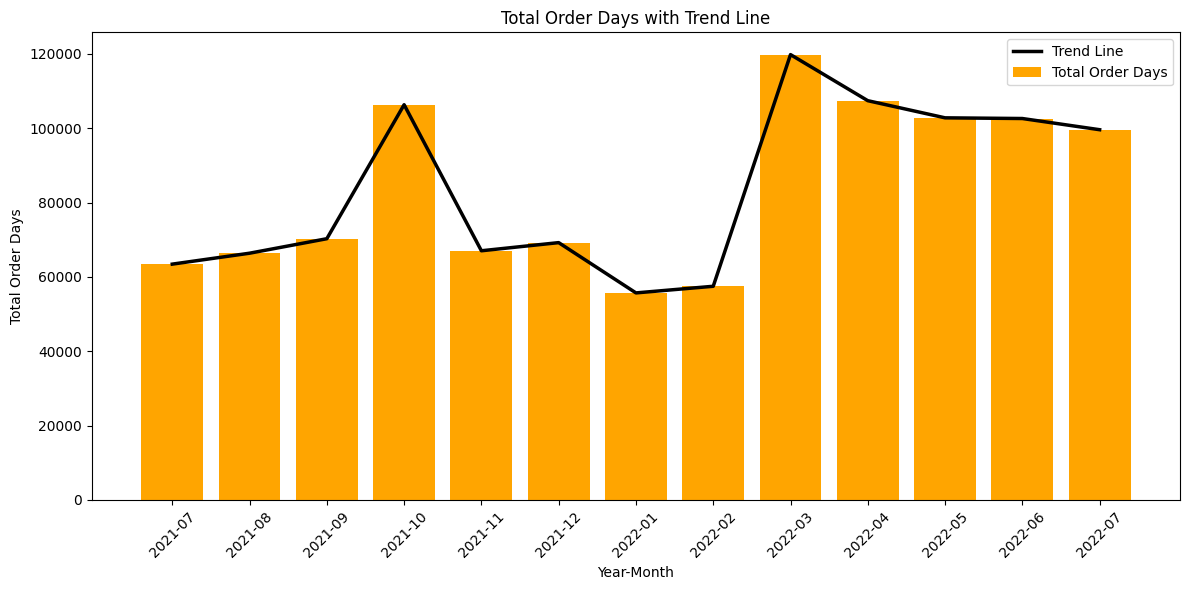

In [256]:
# Groupping data
grouped_data = historical_full_df.groupby('month_year')['order_days'].sum().reset_index()

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(grouped_data['month_year'].astype(str), grouped_data['order_days'], color='orange', label='Total Order Days')

# Temporal series line
plt.plot(grouped_data['month_year'].astype(str), grouped_data['order_days'], color='black', linewidth = 2.5, label='Trend Line')

# General configurations
plt.xlabel('Year-Month')
plt.ylabel('Total Order Days')
plt.title('Total Order Days with Trend Line')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### 4.6 Correlation
Let's check the correlation between order days and transaction amount.

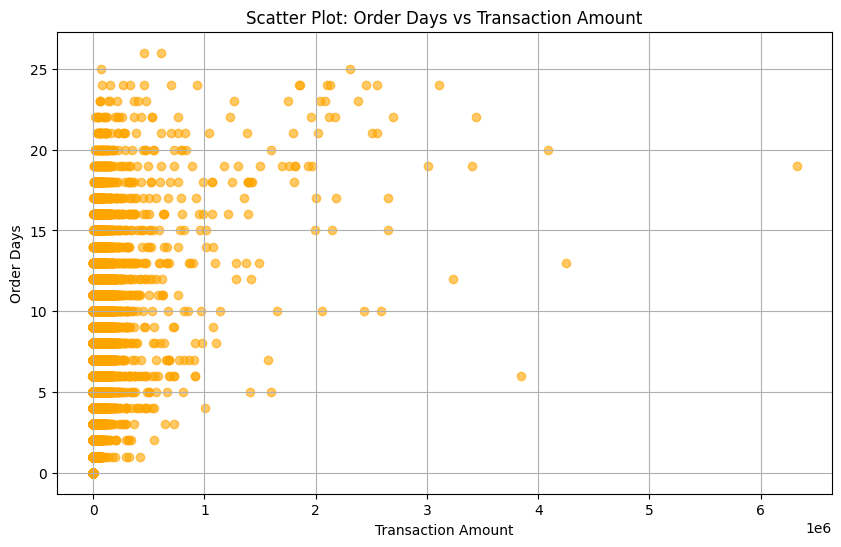

In [257]:
plt.figure(figsize=(10, 6))
plt.scatter(historical_full_df['transaction_amount'], historical_full_df['order_days'], alpha=0.6, color = 'orange')
plt.title('Scatter Plot: Order Days vs Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Order Days')
plt.grid()
plt.show()

There is no linear correlation.

#### 4.7 Business Applications
Let's split the users according to some business rules. We'll divide the user type by: 

    1. Newcomer - Users that started to buy in the last 3 months (2022-07, 2022-06 and 2022-05)
    2. Active Users - Users that bought every month in the past 6 months (2022-07, 2022-06, 2022-05, 2022-04, 2022-03 and 2022-02)
    3. Inactive Users - Users that didn't buy every month in the past 6 months (2022-07, 2022-06, 2022-05, 2022-04, 2022-03 and 2022-02)
    4. Inconsistent Users - Users that does not have a consistency in month-orders

First let's create a list with newcomers.

In [81]:
# Copying newcomer
newcomer_df = historical_orders_date_splitted.copy()

# Creating auxiliary columns for order_days
newcomer_df['order_days_before_may'] = np.where(
    newcomer_df['month_year'] <= '2022-04',
    newcomer_df['order_days'],
    0
)

newcomer_df['order_days_after_may'] = np.where(
    newcomer_df['month_year'] > '2022-04',
    newcomer_df['order_days'],
    0
)

# Aggregating the sums by account_id
result = newcomer_df.groupby('account_id').agg(
    order_days_before_may=('order_days_before_may', 'sum'),
    order_days_after_may=('order_days_after_may', 'sum')
).reset_index()

# List
newcomer_users = result[(result['order_days_before_may'] == 0) & (result['order_days_after_may'] != 0)]['account_id'].tolist()

Now, the active users.

In [82]:
# Creating active users df
active_users_df = historical_orders_date_splitted.copy()

# Converting the 'month_year' column to string in the original DataFrame
active_users_df['month_year'] = active_users_df['month_year'].astype(str)

# Defining the months you want to filter
filtered_months = ['2022-07', '2022-06', '2022-05', '2022-04', '2022-03', '2022-02']

# Creating a new filtered DataFrame
filtered_df = active_users_df[active_users_df['month_year'].isin(filtered_months)].copy()

# Identifying the account_ids that have order_days = 0
account_ids_to_drop = filtered_df[filtered_df['order_days'] == 0]['account_id'].unique()

# Removing the account_ids from filtered_df
filtered_df_final = filtered_df[~filtered_df['account_id'].isin(account_ids_to_drop)].copy()

# List
active_users = filtered_df_final['account_id'].unique().tolist()

Inactive users.

In [83]:
# Copy
inactive_users_df = historical_orders_date_splitted.copy()

# Converting the 'month_year' column to string in the original DataFrame
inactive_users_df['month_year'] = inactive_users_df['month_year'].astype(str)

# Defining the months you want to filter
filtered_months = ['2022-07', '2022-06', '2022-05', '2022-04', '2022-03', '2022-02']

# Creating a new filtered DataFrame
filtered_df = inactive_users_df[inactive_users_df['month_year'].isin(filtered_months)].copy()

# Identifying the account_ids that have all rows with order_days = 0
account_ids_no_purchases = filtered_df.groupby('account_id').filter(lambda x: (x['order_days'] != 0).sum() == 0)['account_id'].unique()

# Removing all account_ids that had purchases
filtered_df_final = filtered_df[filtered_df['account_id'].isin(account_ids_no_purchases)].copy()

# Creating a list of account_ids from the final filtered DataFrame
inactive_users = filtered_df_final['account_id'].unique().tolist()

To complete, inconsistent users.

In [84]:
# Merging the three lists
all_users = newcomer_users + active_users + inactive_users

# Obtaining the unique IDs from historical_full_df
historical_user_ids = historical_full_df['account_id'].unique()

# Creating the list of inconsistent_users
inconsistent_users = [user for user in historical_user_ids if user not in all_users]

Checking if the values are correct.

In [85]:
# Checking integrity of lists
if len(inconsistent_users) + len(active_users) + len(inactive_users) + len(newcomer_users) == historical_orders_date_splitted['account_id'].nunique():
    print("The lists are correct.")
else:
    print("The lists are wrong")

The lists are correct.


Let's check how the account_id (users) are splitted.

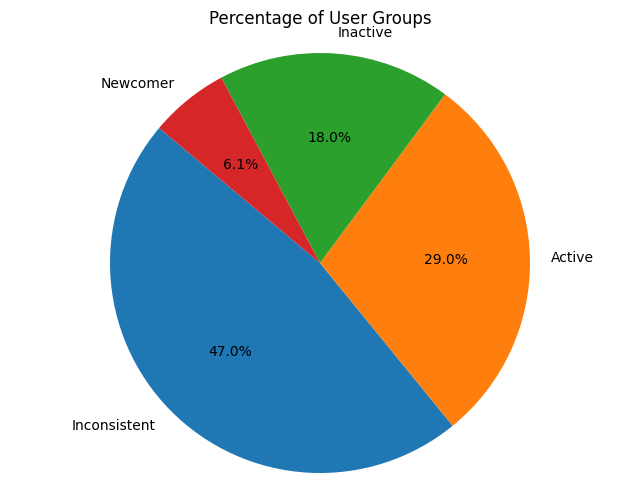

In [86]:
# Calculate the total number of users
total_users = len(inconsistent_users) + len(active_users) + len(inactive_users) + len(newcomer_users)

# Calculate percentages
percentages = [
    len(inconsistent_users) / total_users * 100,
    len(active_users) / total_users * 100,
    len(inactive_users) / total_users * 100,
    len(newcomer_users) / total_users * 100,
]

# Group names
labels = ['Inconsistent', 'Active', 'Inactive', 'Newcomer']

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of User Groups')
plt.axis('equal')  # To ensure the pie chart is a circle
plt.show()

Now, understand what is the average order days per user group.

In [97]:
# Filtering per group
active_users_order_days = historical_full_df[historical_full_df['account_id'].isin(active_users)]
inactive_users_order_days = historical_full_df[historical_full_df['account_id'].isin(inactive_users)]
newcomer_users_order_days = historical_full_df[historical_full_df['account_id'].isin(newcomer_users)]
inconsistent_users_order_days = historical_full_df[historical_full_df['account_id'].isin(inconsistent_users)]

# Calculate and print the mean of 'order_days' for each user group
active_users_mean = active_users_order_days['order_days'].mean().round(2)
inactive_users_mean = inactive_users_order_days['order_days'].mean().round(2)
newcomer_users_mean = newcomer_users_order_days['order_days'].mean().round(2)
inconsistent_users_mean = inconsistent_users_order_days['order_days'].mean().round(2)

# Print
print("Mean of order_days for active users:", active_users_mean)
print("Mean of order_days for inactive users:", inactive_users_mean)
print("Mean of order_days for newcomer users:", newcomer_users_mean)
print("Mean of order_days for inconsistent users:", inconsistent_users_mean)

Mean of order_days for active users: 3.64
Mean of order_days for inactive users: 0.28
Mean of order_days for newcomer users: 0.29
Mean of order_days for inconsistent users: 1.33


Let's run a hyphotesis test in order to understand if these differences are statistically different. Since our distribution is not normal, we'll use Kruskal-Wallis.

In [117]:
# Extracting values
active_users_order_days_values = active_users_order_days['order_days']
inactive_users_order_days_values = inactive_users_order_days['order_days']
newcomer_users_order_days_values = newcomer_users_order_days['order_days']
inconsistent_users_order_days_values = inconsistent_users_order_days['order_days']

# Kruskal-Wallis
stat, p_value = kruskal(
    active_users_order_days_values, 
    inactive_users_order_days_values, 
    newcomer_users_order_days_values, 
    inconsistent_users_order_days_values
)

# Print
(stat, p_value)

(np.float64(224404.82043972035), np.float64(0.0))

#### 4.8 Monthly New Users

Here, we'll understand the incidence of new users through time. This analysis is really important to understand how our model is going to perform, **since the higher the quantity of new users (meaning, users with no historical data), the lower the probability of it predict the proper order days.**

In [264]:
# Copy the original DataFrame
historical_full_df_new_users = historical_orders_crossed.copy()

# Calculate the cumulative sum of transactions up to the previous transaction
historical_full_df_new_users['cumulative_transaction'] = (
    historical_full_df_new_users.groupby('account_id')['transaction_amount'].cumsum()
    - historical_full_df_new_users['transaction_amount']
)

#Identify new users
historical_full_df_new_users['is_new_user'] = (
    (historical_full_df_new_users['cumulative_transaction'] == 0)
    & (historical_full_df_new_users['transaction_amount'] > 0)
).astype(int)

# Count the number of new users per month
new_users_per_month = (
    historical_full_df_new_users.groupby('month_year')['is_new_user'].sum().reset_index()
)

# Rename columns for clarity
new_users_per_month.columns = ['month_year', 'new_users']

# Removing January
new_users_per_month = new_users_per_month[new_users_per_month['month_year'] != '2021-01']

# Display the DataFrame
new_users_per_month

,month_year,new_users
1,2021-02,1348
2,2021-03,845
3,2021-04,705
4,2021-05,815
5,2021-06,771
6,2021-07,792
7,2021-08,751
8,2021-09,3575
9,2021-10,11707
10,2021-11,795


 Average new users per month: 1696.94


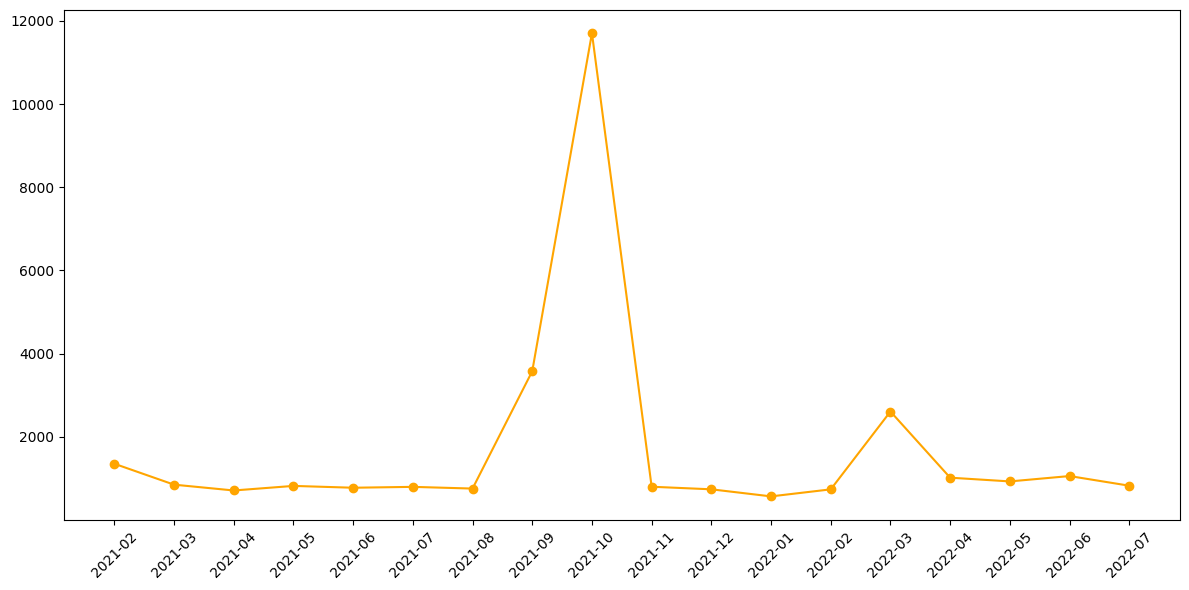

In [265]:
# Sort the DataFrame by 'month_year'
new_users_per_month = new_users_per_month.sort_values('month_year')
new_users_per_month['month_year'] = new_users_per_month['month_year'].astype(str)

# Mean
print(f" Average new users per month: {np.mean(new_users_per_month['new_users']).round(2)}")

# Plot the time series data
plt.figure(figsize=(12,6))
plt.plot(new_users_per_month['month_year'], new_users_per_month['new_users'], marker='o', linestyle='-', color = 'orange')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

October, 2021 (2021-10 ) has the highest number of new users, which means that the prediction of next month (november) would not be precise.

#### 4.8 New Users in August
Let's check if there are any new account_id in August (meaning, account_id is in the august_total_sales but is not in august_historical_data).

In [266]:
# Check for differences
missing_account_ids = august_total_sales_df[~august_total_sales_df['account_id'].isin(historical_orders_df['account_id'])]

# Print shape to find rows
print(f"The quantity of new users in August is {missing_account_ids.shape[0]}")

The quantity of new users in August is 1223


***There are 1223 completely unseen users in August. This information is really important in order to understand how precise our model is going to be. Since the average of new users is 1696.94, there are a significant quantity of less users entering in the month we'll predict, which improve the probability of our model to have a good performance.***

### 5. Data Modeling


For all data modelling, it's important to remember that **we must use a different approach while dividing our train and test set**, since the order matters due to the time series.

Our first model we'll be the **mean per account_id / user** in order to have a baseline for our regression problem. After that, we'll test algorithms like:

    * Generalized Linear Model
    * Random Forest Regressor
    * XGBRegressor

NOTE: As written in the beginning of this notebook, the main metric we'll use is going to be MAE (Mean Absolute Error)**, the reason for this is MAE measures the mean error in real unities and, with this, we could check how many missing days we are making in a month, in addition it doesn't penalizes extreme errors (outliers) like RMSE. RMSE could also be used depending in our results of our historical dataset regarding outliers.

#### 5.1 Model 1 - Mean


Since our data has the same mean and the same median in the past 4 months, let's consider only this sample to create our train and test. So, 3 months for our train set and 1 month to be predicted (test set). Using the information of median and mean from our boxplot, it make sense to start with the basics from data science. Let's try to fit our data using the mean and median as our first model.

NOTE: Here, we'll not going to use our dataset with LAGs, because there we probably lost some users that, in this case, is relevant.

In [20]:
# Dividing into train and test
train_mean_df = historical_full_df[(historical_full_df['month_year'] >= '2022-04') & (historical_full_df['month_year'] <= '2022-06')]
test_mean_df = historical_full_df[historical_full_df['month_year'] == '2022-07']

Calculating the mean and median from our train and test.

In [21]:
# Calculating median and mean
statistical_measures_user_results = train_mean_df.groupby('account_id')['order_days'].agg(
    mean_y_pred='mean',
    median_y_pred='median'
).round(0).astype(int).reset_index()

# Print
statistical_measures_user_results.head()

,account_id,mean_y_pred,median_y_pred
0,BR_00000343803,2,2
1,BR_00001415930,1,1
2,BR_00001545205,0,0
3,BR_00001760106,5,5
4,BR_00002485176,4,4


Consolidating all predictions in a single dataset.

In [22]:
# Performing the join between mean_user_results and test_df
test_df_with_mean = test_mean_df.merge(statistical_measures_user_results, on='account_id', how='left')

# Selecting only the desired columns and renaming mean_order_days to pred_order_days
test_df_final = test_df_with_mean[['account_id', 'order_days', 'mean_y_pred', 'median_y_pred']]

# Displaying the first rows of the resulting DataFrame
test_df_final.head()

,account_id,order_days,mean_y_pred,median_y_pred
0,BR_00000343803,4,2,2
1,BR_00001415930,4,1,1
2,BR_00001545205,0,0,0
3,BR_00001760106,4,5,5
4,BR_00002485176,1,4,4


Calculating the RMSE, MAE and MSE.

In [23]:
# Calculating metrics of evaluation
mean_mae = mean_absolute_error(test_df_final['order_days'], test_df_final['mean_y_pred']).round(2)
mean_rmse = np.sqrt(mean_squared_error(test_df_final['order_days'], test_df_final['mean_y_pred'])).round(2)
mean_mse = mean_squared_error(test_df_final['order_days'], test_df_final['mean_y_pred']).round(2)

median_mae = mean_absolute_error(test_df_final['order_days'], test_df_final['median_y_pred']).round(2)
median_rmse = np.sqrt(mean_squared_error(test_df_final['order_days'], test_df_final['median_y_pred'])).round(2)
median_mse = mean_squared_error(test_df_final['order_days'], test_df_final['median_y_pred']).round(2)

# Print
print("For the mean:")
print(f"RMSE: {mean_rmse}")
print(f"MSE: {mean_mse}")
print(f"MAE: {mean_mae}")
print("\n")
print("For the median:")
print(f"RMSE: {median_rmse}")
print(f"MSE: {median_mse}")
print(f"MAE: {median_mae}") 

For the mean:
RMSE: 1.39
MSE: 1.95
MAE: 0.89


For the median:
RMSE: 1.45
MSE: 2.12
MAE: 0.91


The MAE was better for the mean.

MAE of 0.89 means that, on average, this model is predicting 0.89 days more or less (so if an user has 4 order days, our model is predicting 3 or 5, since there is no half day).

#### 5.2 Model 2 - Generalized Linear Model (GLM)

Creating train and test sets. First, let's try using the train_df from the beginning of the dataset until 2022-06. 

In [24]:
# Dividing into train and test
train_GLR_df = historical_full_df[historical_full_df['month_year'] <= '2022-05']
test_GLR_df = historical_full_df[historical_full_df['month_year'] > '2022-05']

In [25]:
X_train = train_GLR_df[['year', 'month', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_1', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_4', 'order_days_lag_5', 'order_days_lag_6']] 
y_train = train_GLR_df['order_days']     

X_test = test_GLR_df[['year', 'month', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_1', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_4', 'order_days_lag_5', 'order_days_lag_6']] 
y_test = test_GLR_df['order_days']

Fitting model.

In [26]:
model_GLR_1 = sm.GLM(y_train, X_train).fit()
print(model_GLR_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             order_days   No. Observations:               526889
Model:                            GLM   Df Residuals:                   526878
Model Family:                Gaussian   Df Model:                           10
Link Function:               Identity   Scale:                          1.8690
Method:                          IRLS   Log-Likelihood:            -9.1238e+05
Date:                Tue, 05 Nov 2024   Deviance:                   9.8475e+05
Time:                        07:58:41   Pearson chi2:                 9.85e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8510
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Prediction and calculation of metrics.

In [27]:
# Calculating y_pred
y_pred = model_GLR_1.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Print
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 0.9827
RMSE: 1.3814


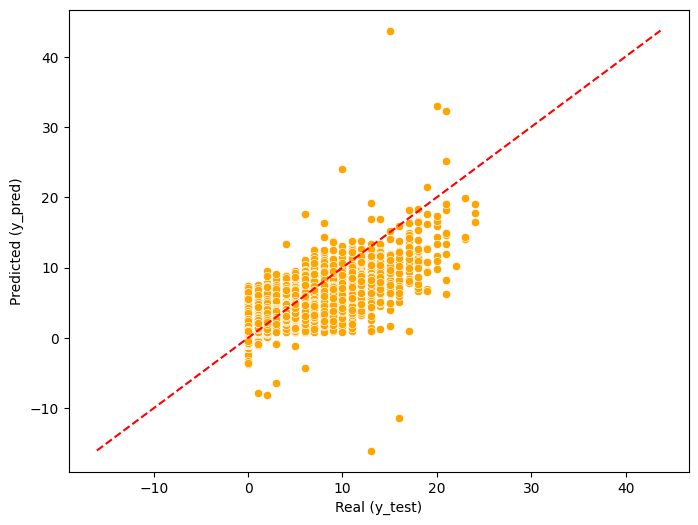

In [29]:
# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color = 'orange')

# Adding line
max_value = max(y_test.max(), y_pred.max())
min_value = min(y_test.min(), y_pred.min())
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')

# General configurations
plt.xlabel("Real (y_test)")
plt.ylabel("Predicted (y_pred)")
plt.show()

The value we found above of MAE is higher than the mean of our model 1 (0.89).  

Let's try using a different approach. Since we have a poisson distribution, let's change the family of our GLM. Since we have a Poisson distribution, let's go for it.

In [30]:
model_GLR_2 = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit(method="lbfgs")
print(model_GLR_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             order_days   No. Observations:               526889
Model:                            GLM   Df Residuals:                   526878
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:            -5.6125e+05
Date:                Tue, 05 Nov 2024   Deviance:                   3.6634e+05
Time:                        07:58:59   Pearson chi2:                 4.45e+05
No. Iterations:                     0   Pseudo R-squ. (CS):             0.9054
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [31]:
# Calculating y_pred
y_pred = model_GLR_2.predict(X_test).round(0)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Print
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 0.8532
RMSE: 1.5957


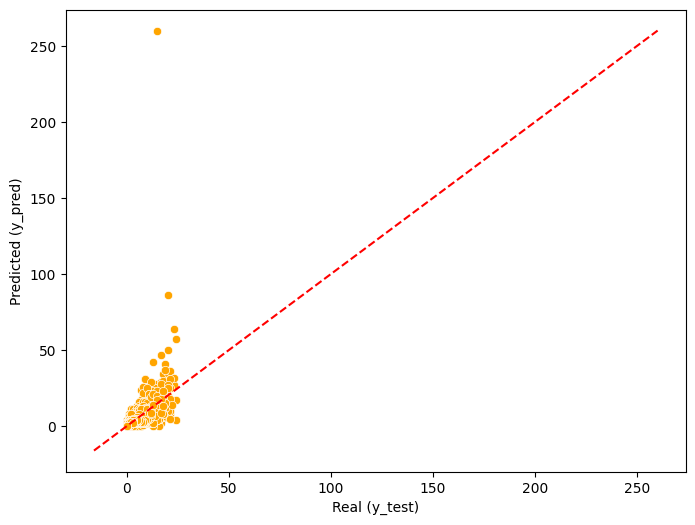

In [32]:
# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color = 'orange')

# Adding line
max_value = max(y_test.max(), y_pred.max())
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')

# General configurations
plt.xlabel("Real (y_test)")
plt.ylabel("Predicted (y_pred)")
plt.show()

Our MAE increased and is lower than the GLM (using gaussian), but still not lower than the mean (our base line).

#### 5.3 Model 3 - Random Forest Regressor

In [33]:
# Dividing into train and test
train_RFR_df = historical_full_df[historical_full_df['month_year'] <= '2022-06']
test_RFR_df = historical_full_df[historical_full_df['month_year'] == '2022-07']

In [50]:
X_train = train_RFR_df[['year', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_1', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_4', 'order_days_lag_6']]
y_train = train_RFR_df['order_days']       

X_test = test_RFR_df[['year', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_1', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_4', 'order_days_lag_6']]
y_test = test_RFR_df['order_days']

In [51]:
# Modeling
model_rgr =  RandomForestRegressor().fit(X_train, y_train)

In [52]:
# Calculating y_pred
y_pred = model_rgr.predict(X_test)

# Calculating evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Calculating RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print
print(f"MAE: {mae.round(2)}")
print(f"RMSE: {rmse}")

MAE: 0.67
RMSE: 1.0976644932166095


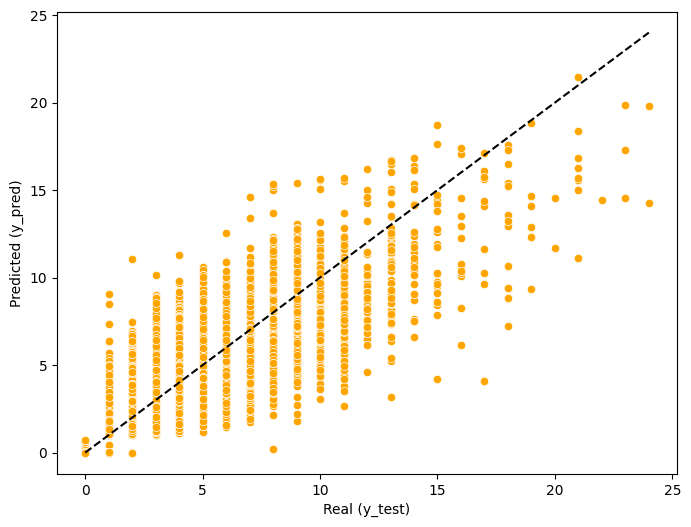

In [53]:
# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color = 'orange')

# Adding line
max_value = max(y_test.max(), y_pred.max())
min_value = min(y_test.min(), y_pred.min())
plt.plot([min_value, max_value], [min_value, max_value], color='black', linestyle='--')

# General configurations
plt.xlabel("Real (y_test)")
plt.ylabel("Predicted (y_pred)")
plt.show()

Now we've found a better MAE but with a bad performance. We could try to iterate using all features but since we're using a random forest, it will take hours and, for our proposal of delivery this project in a week, we'll not continue with this model.

#### 5.4 Model 4 - XGBRegressor

##### 5.4.1 Transaction Amount

First, let's start our model by only using the transaction amount.

In [59]:
# Dividing into train and test
train_XGBR_df = historical_full_df[historical_full_df['month_year'] <= '2022-06']
test_XGBR_df = historical_full_df[historical_full_df['month_year'] == '2022-07']

In [60]:
X_train = train_XGBR_df[[ 'year', 'month', 'transaction_amount']]
y_train = train_XGBR_df['order_days']       

X_test = test_XGBR_df[[ 'year', 'month', 'transaction_amount']]
y_test = test_XGBR_df['order_days']

In [61]:
# Modeling
model_xgb = XGBRegressor().fit(X_train, y_train)

In [62]:
# Calculating y_pred
y_pred = model_xgb.predict(X_test).round(0)

# Calculating evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Calculating RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print
print(f"MAE: {mae.round(2)}")
print(f"RMSE: {rmse}")

MAE: 0.72
RMSE: 1.3156257857640161


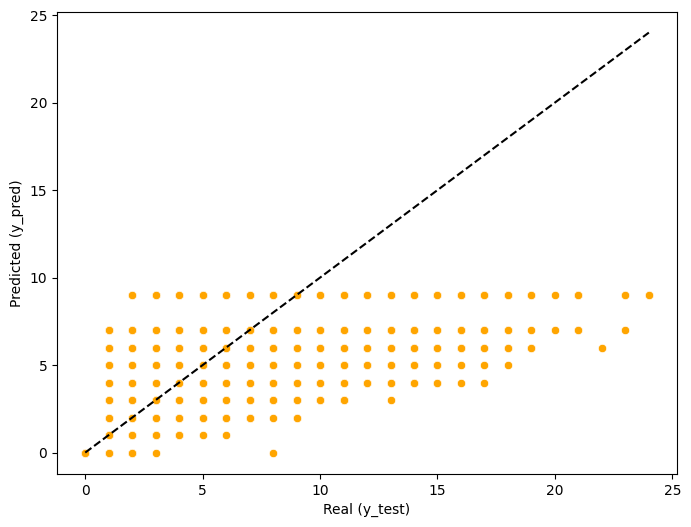

In [63]:
# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color = 'orange')

# Adding line
max_value = max(y_test.max(), y_pred.max())
min_value = min(y_test.min(), y_pred.min())
plt.plot([min_value, max_value], [min_value, max_value], color='black', linestyle='--')

# General configurations
plt.xlabel("Real (y_test)")
plt.ylabel("Predicted (y_pred)")
plt.show()

For now, we could find a better model that is better when comparing with our baseline (using mean) of 0.89. Let's dive in by adding the LAGs

##### 5.4.2 LAG

In [64]:
# Dividing into train and test
train_XGBR_df = historical_full_df[historical_full_df['month_year'] <= '2022-06']
test_XGBR_df = historical_full_df[historical_full_df['month_year'] == '2022-07']

In [65]:
X_train = train_XGBR_df[[ 'year', 'month', 'transaction_amount', 'order_days_lag_1', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_4', 'order_days_lag_5', 'order_days_lag_6']]
y_train = train_XGBR_df['order_days']       

X_test = test_XGBR_df[[ 'year', 'month', 'transaction_amount', 'order_days_lag_1', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_4', 'order_days_lag_5', 'order_days_lag_6']]
y_test = test_XGBR_df['order_days']

In [66]:
# Modeling
model_xgb = XGBRegressor().fit(X_train, y_train)


# Calculating y_pred
y_pred = model_xgb.predict(X_test).round(0)

# Calculating evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Calculating RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print
print(f"MAE: {mae.round(2)}")
print(f"RMSE: {rmse}")

MAE: 0.63
RMSE: 1.1365744581801285


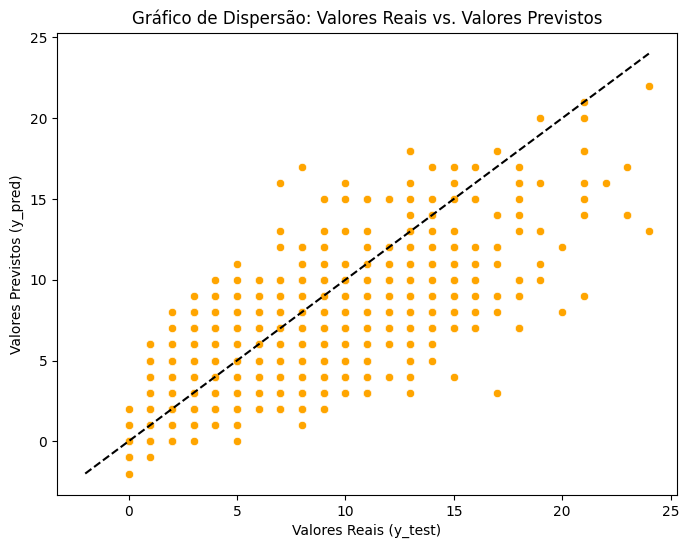

In [67]:
# Criando o scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color = 'orange')

# Adicionando uma linha de identidade para referência
max_value = max(y_test.max(), y_pred.max())
min_value = min(y_test.min(), y_pred.min())
plt.plot([min_value, max_value], [min_value, max_value], color='black', linestyle='--')

# Configurações adicionais do gráfico
plt.xlabel("Valores Reais (y_test)")
plt.ylabel("Valores Previstos (y_pred)")
plt.title("Gráfico de Dispersão: Valores Reais vs. Valores Previstos")
plt.show()

We had a small improvement comparing to the last try.

##### 5.4.4 Feature Selection

Let's try to improve our MAE by iterating among our features to understand what is the best combination for MA

In [ ]:
# Defining attributes
feature_columns = ['year', 'month', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_1', 'order_days_lag_2','order_days_lag_3', 'order_days_lag_4', 'order_days_lag_5','order_days_lag_6']

# Generating varibles for combination
best_mae = float('inf')
best_combination = None

# Iterating
for r in range(1, len(feature_columns) + 1):
  for combination in itertools.combinations(feature_columns, r):
    # Selecing combination
    X_train_comb = train_XGBR_df[list(combination)]
    X_test_comb = test_XGBR_df[list(combination)]
        
    # Training
    model_xgb = XGBRegressor().fit(X_train_comb, y_train)
        
    # Calculating y_pred
    y_pred = model_xgb.predict(X_test_comb)
        
    # Calculating MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Comparing combinations
    if mae < best_mae:
        best_mae = mae
        best_combination = combination

# Print
print(f"Best combination: {best_combination}")
print(f"Best MAE: {best_mae}")

Best combination: ('year', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_5', 'order_days_lag_6')
Best MAE: 0.5879501409797983


##### 5.4.5 Final Model

So now we have our final combination for this model. 

In [124]:
# Dividing into train and test
train_XGBR_df = historical_full_df[historical_full_df['month_year'] <= '2022-06']
test_XGBR_df = historical_full_df[historical_full_df['month_year'] == '2022-07']

In [125]:
X_train = train_XGBR_df[['year', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_5', 'order_days_lag_6']]
y_train = train_XGBR_df['order_days']       

X_test = test_XGBR_df[['year', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_5', 'order_days_lag_6']]
y_test = test_XGBR_df['order_days']

In [126]:
# Modeling
model_xgb = XGBRegressor().fit(X_train, y_train) 

# Calculating y_pred
y_pred = model_xgb.predict(X_test).round(0)

# Calculating evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Calculating RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print
print(f"MAE: {mae.round(2)}")
print(f"RMSE: {rmse}")

MAE: 0.56
RMSE: 1.037663152096848


Let's deep dive into the residuals.

In [121]:
# Creating Dataframe with y_pred, y_test and residuals
xgb_residuals = pd.DataFrame({
    "y_test": y_test,
    "y_pred": abs(y_pred).astype(int),
    "residuals": abs(y_test - y_pred).astype(int)
})

# Statistics
xgb_residuals.describe()

,y_test,y_pred,residuals
count,47899.000000,47899.000000,47899.000000
mean,2.079939,2.113990,0.560158
std,2.262913,2.051722,0.873490
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,2.000000,2.000000,0.000000
75%,3.000000,3.000000,1.000000
max,24.000000,22.000000,13.000000


Our max y_test is 24 order_days and our model predicted 22. The higher residuals value is 13. 

The mean of the y_test and y_pred is quite the same, which is good. 

The outliers are putting the MAE up.

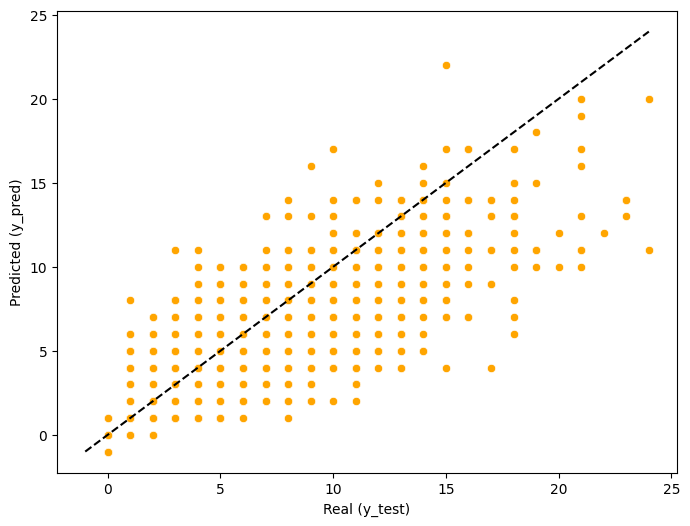

In [122]:
# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color = 'orange')

# Adding line
max_value = max(y_test.max(), y_pred.max())
min_value = min(y_test.min(), y_pred.min())
plt.plot([min_value, max_value], [min_value, max_value], color='black', linestyle='--')

# General configurations
plt.xlabel("Real (y_test)")
plt.ylabel("Predicted (y_pred)")
plt.show()

<Axes: xlabel='residuals', ylabel='Count'>

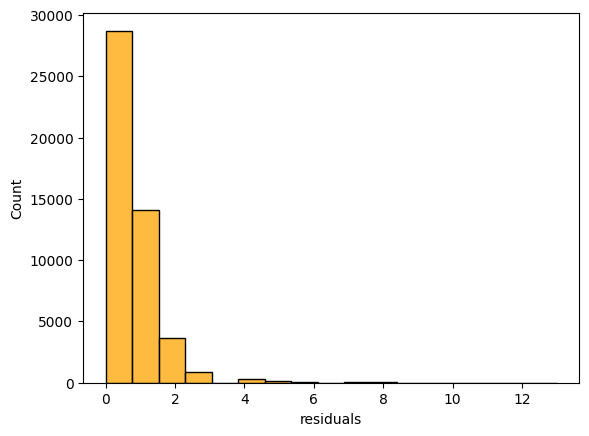

In [73]:
sns.histplot(xgb_residuals['residuals'], bins = 17, color = 'orange')

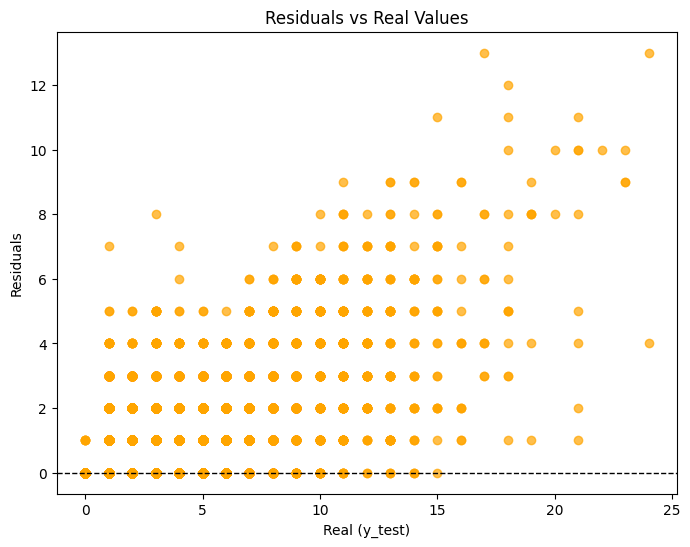

In [74]:
# Gráfico de Dispersão dos Resíduos em relação aos Valores Reais (y_test)
plt.figure(figsize=(8, 6))
plt.scatter(xgb_residuals['y_test'], xgb_residuals['residuals'], color='orange', alpha=0.7)
plt.xlabel("Real (y_test)")
plt.ylabel("Residuals")
plt.title("Residuals vs Real Values")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

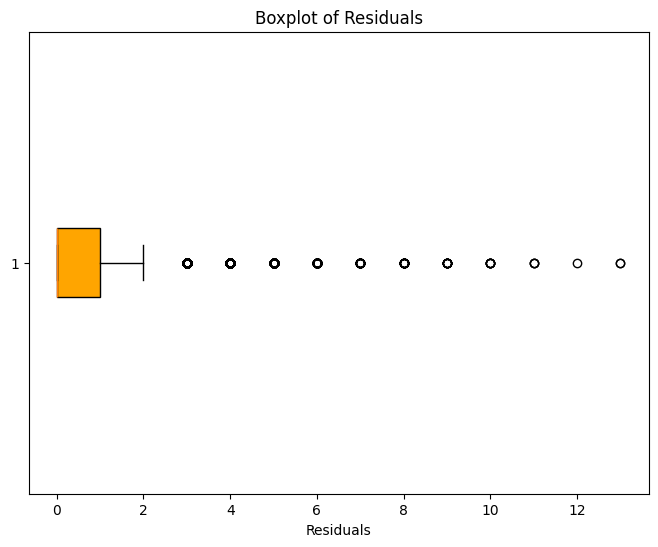

In [75]:
plt.figure(figsize=(8, 6))
plt.boxplot(xgb_residuals['residuals'], vert=False, patch_artist=True, boxprops=dict(facecolor='orange'))
plt.xlabel("Residuals")
plt.title("Boxplot of Residuals")
plt.show()

Now, since this is our best model, let's go for the cross validation.

**NOTE: we'll use time series split in order to keep the order of dates!**

In [76]:
# Defining unique months to use in TimeSeriesSplit
months = historical_full_df['month_year'].unique()

# Configuring TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=8)

# Creating the model
model = XGBRegressor()

# List to store MAE results for each fold
mae_scores = []

# Iterating over each fold in TimeSeriesSplit
for split_num, (train_months_index, test_months_index) in enumerate(tscv.split(months)):
    # Selecting training and testing months for each split
    train_months = months[train_months_index]
    test_months = months[test_months_index]
    
    # Converting the arrays to lists of strings for cleaner display
    train_months_list = train_months.astype(str).tolist()
    test_months_list = test_months.astype(str).tolist()
    
    # Creating training and testing sets based on selected months
    train_XGBR_df = historical_full_df[historical_full_df['month_year'].isin(train_months)]
    test_XGBR_df = historical_full_df[historical_full_df['month_year'].isin(test_months)]
    
    # Selecting independent variables and the target variable for training and testing
    X_train = train_XGBR_df[['year', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_5', 'order_days_lag_6']]
    y_train = train_XGBR_df['order_days']
    
    X_test = test_XGBR_df[['year', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_5', 'order_days_lag_6']]
    y_test = test_XGBR_df['order_days']
    
    # Training the model on the training set
    model.fit(X_train, y_train)
    
    # Making predictions on the test set
    predictions = model.predict(X_test)
    
    # Calculating MAE and storing the result
    mae = mean_absolute_error(y_test, predictions)
    mae_scores.append(mae)
    
    # Displaying the current split and MAE
    print(f"Fold {split_num + 1}:")
    print("Training Months:", train_months_list)
    print("Testing Month:", test_months_list)
    print("MAE:", mae.round(2))
    print()

# Displaying the average MAE across folds
average_mae = sum(mae_scores) / len(mae_scores)
print("Average MAE across all folds:", average_mae.round(2))


Fold 1:
Training Months: ['2021-07', '2021-08', '2021-09', '2021-10', '2021-11']
Testing Month: ['2021-12']
MAE: 0.39

Fold 2:
Training Months: ['2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12']
Testing Month: ['2022-01']
MAE: 0.35

Fold 3:
Training Months: ['2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01']
Testing Month: ['2022-02']
MAE: 0.36

Fold 4:
Training Months: ['2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02']
Testing Month: ['2022-03']
MAE: 0.82

Fold 5:
Training Months: ['2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03']
Testing Month: ['2022-04']
MAE: 0.64

Fold 6:
Training Months: ['2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04']
Testing Month: ['2022-05']
MAE: 0.62

Fold 7:
Training Months: ['2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-0

**While predicting MARCH 2021 (2021-03), the MAE increased from 0.36 to 0.82. According to our EDA, this could be because of the quantity of new users on March, making the model not able to predict properly.**

Now we'll try to improve our hyperparameters by using GridSearch.

NOTE: the XBGRegressor paramethers were taken from: https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.ensemble.XGBRegressor and https://xgboosting.com/

In [379]:
# Param grid
param_grid = {
    'n_estimators': [200, 100],                
    'learning_rate': [0.1, 0.3],        
    'max_depth': [3, 4, 6],                       
    'min_child_weight': [1, 3, 5],      
    'subsample': [0.8, 1.0],                  
    'colsample_bytree': [1.0, 1],           
    'reg_alpha': [0.1, 0],                     
    'reg_lambda': [1],                    
}

# Defining model
model_xgb = XGBRegressor()

# Grid Search
grid_search = GridSearchCV(estimator=model_xgb, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Checking model
grid_search.fit(X_train, y_train)

# Results
print("Best paramethers:", grid_search.best_params_)
print("Best negative MSE:", grid_search.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best paramethers: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Best negative MSE: -0.8158715559877219


In [123]:
params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 5,
    'n_estimators': 200,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'subsample': 1.0
}

# Modeling
model_xgb = XGBRegressor().fit(X_train, y_train) 

# Calculating y_pred
y_pred = model_xgb.predict(X_test).round(0)

# Calculating evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Calculating RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print
print(f"MAE: {mae.round(2)}")
print(f"RMSE: {rmse}")

MAE: 0.56
RMSE: 1.037663152096848


Let's run a statistical test (Wilcoxon) in order to understand the significance of the difference of our final model to the base line (mean). We'll use this test since it's a non parametric distribution and we're comparing before and after for each user (before = mean, after = model).

In [133]:
# Calculating the errors
mean_errors = abs(test_df_final['order_days'] - test_df_final['mean_y_pred'])
model_errors = abs(y_test - y_pred )

# Wilcox
stat, p_value = wilcoxon(model_errors, mean_errors)

# Print
print(f'Statistics: {stat}, p-valor: {p_value}')

Statistics: 62095059.0, p-valor: 0.0


Since our p-value is lower than 0.05, we could inference, **with 95% of confidence**, that our errors are different between both samples. In our case, the errors of our model are lower when comparing to our baseline.

### 6. Prediction

For the prediction, **we are going to use the august total sales as our input. But, we'll subtract the august missing orders to predict only the remainning days of August.**

#### 6.1 Input Preparation (August Missing Orders)

Adjusting the column type.

In [393]:
# Copy
august_missing_order_dated_df = august_missing_order_days_df.copy()

# Converting the data attributes
august_missing_order_dated_df['order_date'] = pd.to_datetime(august_missing_order_dated_df['order_date'])

# Print
august_missing_order_dated_df.head()

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52
2,BR_09532176632,2022-08-03,24.90
3,BR_09532176632,2022-08-03,28.50
4,BR_09532176632,2022-08-03,11.16


Grouping per order_days.

For a businses perspective, **WE'LL CONSIDER DAYS WITH TRANSACTION = 0 AS A DAY WITH NO ORDER, SO LET'S DROP IT**.

NOTE: This is only done because we don't have access to the business department, if so, we would understand what this NaN and None represents. 

In [394]:
# Copy
august_grouped_df = august_missing_order_dated_df.copy()

# Grouping by account_id and order_date
august_grouped_df = august_grouped_df.groupby(['account_id', 'order_date']).agg(transaction_amount = ('transaction_amount', 'sum')).reset_index()
august_grouped_df['month_year'] = august_grouped_df['order_date'].dt.to_period('M')
august_grouped_df = august_grouped_df.groupby(['account_id', 'month_year']).agg(transaction_amount=('transaction_amount', 'sum'), order_days=('transaction_amount', 'count')).reset_index()

# Dropping rows when transaction_amount is zero
august_grouped_df = august_grouped_df[august_grouped_df['transaction_amount'] != 0]

# Print
august_grouped_df.head()

,account_id,month_year,transaction_amount,order_days
0,BR_00002485176,2022-08,327.98,2
1,BR_00002536340,2022-08,2338.76,1
2,BR_00009144366,2022-08,114.90,1
3,BR_00014989670,2022-08,13274.25,4
4,BR_00015964540,2022-08,349.98,3


#### 6.2 Input Preparation (August Total Sales)

Since our august total sales will be our input data in order to predict, let's check if our august total sales has any duplicated.

In [395]:
# Count duplicated
duplicate_count = august_total_sales_df.duplicated().sum()
print(f"Total duplicated users: {duplicate_count}")


Total duplicated users: 0


Now, let's store the account_ids to add in the final predition.

In [396]:
# Creating list
account_ids = august_total_sales_df['account_id']

The next step it to left join all_accounts with august_total_sales_df and replacing NaNs for 0 (because if an user is not in august_total_sales, there is no order days there)

Before continuing, let's check if there is any account_id in `total_transaction_amount_august` with 0 that has a transaction in `august_missing_order_days_df`.

In [397]:
# Creating copy of input data
input_august_sales = august_total_sales_df.copy()

# Filtering account_ids in august_sales_full with total_transaction_amount_august equal to 0
zero_transactions = input_august_sales[input_august_sales['total_transaction_amount_august'] == 0]

# Collecting the corresponding account_ids
zero_account_ids = zero_transactions['account_id'].unique()

# Filtering august_missing_order_days_df to check if transaction_amount is different from 0 or NaN
filtered_missing_orders = august_missing_order_days_df[
    (august_missing_order_days_df['account_id'].isin(zero_account_ids)) & 
    (august_missing_order_days_df['transaction_amount'].notna()) & 
    (august_missing_order_days_df['transaction_amount'] != 0)
]

# Checking if there are any records that meet the criteria
if not filtered_missing_orders.empty:
    print("There are account_ids with total_transaction_amount_august equal to 0 and transaction_amount different from 0 or NaN:")
    print(filtered_missing_orders[['account_id', 'transaction_amount']])
else:
    print("No account_id meets the specified criteria.")

No account_id meets the specified criteria.


Now let's remove the value we have in august missing orders.

In [398]:
# Realiza a junção com base na coluna 'account_id' usando left join
merged_df = pd.merge(input_august_sales, august_grouped_df, on='account_id', how='left')

# Filling with 0
merged_df = merged_df.fillna(0)

# Subtracting
merged_df['new_transaction_amount'] = merged_df['total_transaction_amount_august'] - merged_df['transaction_amount']

# Removing unnused columns
merged_df = merged_df.drop(columns=['total_transaction_amount_august', 'month_year', 'transaction_amount', 'order_days'])

# Copy
input_august_sales = merged_df.copy()

# Print
input_august_sales.head()

,account_id,new_transaction_amount
0,BR_00000343803,309.99
1,BR_00001415930,874.98
2,BR_00001760106,11976.70
3,BR_00002485176,183.50
4,BR_00002536340,4742.38


Adding the year and month columns.

In [399]:
# Adding a column with year and month
input_august_sales['month_year'] = '2022-08'

# Transforming to date
input_august_sales['month_year'] = pd.Period('2022-08', freq='M')

# Creating year and month attributes
input_august_sales['year'] = input_august_sales['month_year'].dt.year
input_august_sales['month'] = input_august_sales['month_year'].dt.month

# Renaming transaction attribue
input_august_sales.rename(columns={'new_transaction_amount': 'transaction_amount'}, inplace=True)

# Print
input_august_sales.head()

,account_id,transaction_amount,month_year,year,month
0,BR_00000343803,309.99,2022-08,2022,8
1,BR_00001415930,874.98,2022-08,2022,8
2,BR_00001760106,11976.70,2022-08,2022,8
3,BR_00002485176,183.50,2022-08,2022,8
4,BR_00002536340,4742.38,2022-08,2022,8


Adding the cumulative average.

In [405]:
# Make a copy of `historical_full_df`
historical_full_df_updated = historical_full_df.copy()

# Make a copy of `input_august_sales`
august_cumulative_average = input_august_sales.copy()

# Select only relevant columns from `historical_full_df_updated`
historical_full_df_updated = historical_full_df_updated[['account_id', 'month', 'month_year', 'year', 'transaction_amount']]

# Concatenate the `input_august_sales` data to `historical_full_df_updated`
historical_full_df_updated = pd.concat([historical_full_df_updated, august_cumulative_average], ignore_index=True)

# Sort the DataFrame by `account_id` and `month_year`, then reset the index
historical_full_df_updated = historical_full_df_updated.sort_values(by=['account_id', 'month_year']).reset_index(drop=True)

# Cumulative Average
historical_full_df_updated['cumulative_mean_per_transaction_amount'] = (historical_full_df_updated.groupby('account_id')['transaction_amount'].transform(lambda x: x.expanding(min_periods=1).mean()))

# Function for months with no purschases
def count_months_without_purchases(transaction_amount_series):
    count = 0
    no_purchase_months = []
    for transaction_amount in transaction_amount_series:
        if transaction_amount == 0:
            count += 1
        else:
            count = 0
        no_purchase_months.append(count)
    return no_purchase_months

# Aplying for each account_id
historical_full_df_updated['months_without_purchase'] = (historical_full_df_updated.groupby('account_id')['transaction_amount'].transform(count_months_without_purchases))

# Keep only rows where `month_year` is equal to 2022-08
historical_full_df_updated = historical_full_df_updated[historical_full_df_updated['month_year'] == '2022-08'].reset_index(drop=True)

# Display the first 40 rows for verification
historical_full_df_updated.head()

,account_id,month,month_year,year,transaction_amount,cumulative_mean_per_transaction_amount,months_without_purchase
0,BR_00000343803,8,2022-08,2022,309.99,1062.987143,0
1,BR_00001415930,8,2022-08,2022,874.98,220.921429,0
2,BR_00001760106,8,2022-08,2022,11976.70,3444.811429,0
3,BR_00002485176,8,2022-08,2022,183.50,168.721429,0
4,BR_00002536340,8,2022-08,2022,4742.38,3713.872857,0


Now we'll add LAGs.

In [406]:
# Copy
input_august_sales_lag = historical_full_df_updated.copy()

# Adding order_days_lag_2
historical_june = historical_full_df[historical_full_df['month_year'] == '2022-06']
historical_june = historical_june[['account_id', 'order_days']].rename(columns={'order_days': 'order_days_lag_2'})
input_august_sales_lag = pd.merge(input_august_sales_lag, historical_june, on='account_id', how='left')

# Adding order_days_lag_3 
historical_may = historical_full_df[historical_full_df['month_year'] == '2022-05']
historical_may = historical_may[['account_id', 'order_days']].rename(columns={'order_days': 'order_days_lag_3'})
input_august_sales_lag = pd.merge(input_august_sales_lag, historical_may, on='account_id', how='left')

# Adding order_days_lag_5
historical_april = historical_full_df[historical_full_df['month_year'] == '2022-03']
historical_april = historical_april[['account_id', 'order_days']].rename(columns={'order_days': 'order_days_lag_5'})
input_august_sales_lag = pd.merge(input_august_sales_lag, historical_april, on='account_id', how='left')

# Adding order_days_lag_6
historical_feb = historical_full_df[historical_full_df['month_year'] == '2022-02']
historical_feb = historical_feb[['account_id', 'order_days']].rename(columns={'order_days': 'order_days_lag_6'})
input_august_sales_lag = pd.merge(input_august_sales_lag, historical_feb, on='account_id', how='left')

# Reorder columns and removing the ones that are not features
new_order = ['year', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_5', 'order_days_lag_6']
input_august_sales_lag = input_august_sales_lag[new_order]

# Replacing NaNs for Zeros for the users with no data
input_august_sales_lag.fillna(0, inplace=True)

# Display
input_august_sales_lag.head()

,year,transaction_amount,cumulative_mean_per_transaction_amount,months_without_purchase,order_days_lag_2,order_days_lag_3,order_days_lag_5,order_days_lag_6
0,2022,309.99,1062.987143,0,2.0,3.0,4.0,4.0
1,2022,874.98,220.921429,0,1.0,2.0,0.0,0.0
2,2022,11976.70,3444.811429,0,5.0,5.0,5.0,0.0
3,2022,183.50,168.721429,0,5.0,4.0,3.0,0.0
4,2022,4742.38,3713.872857,0,4.0,4.0,4.0,1.0


In [407]:
# Renaming the dataset
input_august_data = input_august_sales_lag.copy()

#### 6.3 Train All Dataset

In [409]:
# Defining features and target
X = historical_full_df[['year', 'transaction_amount', 'cumulative_mean_per_transaction_amount', 'months_without_purchase', 'order_days_lag_2', 'order_days_lag_3', 'order_days_lag_5', 'order_days_lag_6']]
y = historical_full_df['order_days']

# Trainning model with all our historical data
final_model = XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=5,
    n_estimators=200,
    reg_alpha=0,
    reg_lambda=1,
    subsample=1.0
)

# Fit
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [410]:
# Predictions
y_pred = final_model.predict(input_august_data)

# Rounding
y_pred = abs(y_pred.round(0))

In [411]:
# Creating new dataframe
predicted_order_days = pd.DataFrame({'prediction': y_pred})

# Adding account_ids
predicted_order_days['account_id'] = account_ids

# Reorder
predicted_order_days = predicted_order_days[['account_id', 'prediction']]

# To integer
predicted_order_days['prediction'] = predicted_order_days['prediction'].astype(int)

# Display
predicted_order_days.head()

,account_id,prediction
0,BR_00000343803,2
1,BR_00001415930,2
2,BR_00001760106,5
3,BR_00002485176,2
4,BR_00002536340,4


Checking shape to match the criteria of the exercise (it must be 32944 x 2)

In [419]:
if predicted_order_days.shape == (32944, 2):
    print(f"The archieve shape is corret.")
else:
    print(f"The archieve shape is incorret.")

The archieve shape is corret.


Now let's save as CSV.

In [415]:
# Path
path = r"D:\Bruno Serra PC\Documents\Bruno\Visual Studio\AB Inbev - Data Test\order_days_prediction.csv"

# Saving
predicted_order_days.to_csv(path, index=False)

## STATISTICS

### 2a. Describe the Distribution

**Describe the distribution of the number of order days for a user (or group of users) using a known probability distribution? Propose a formula or density function and provide an explanation for your solution.**

The distribution of the order days from a user or group of users is a POISSON DISTRIBUTION, which is a discrete distribution, since this distribution models the probability of a given number of independent events occur within a fixed time (or space) that has the same variance and mean. In our case, it's the probability of a user buy *X* days in each month.  The PMF (probability mass function) is given by:

$P(X = k) = \frac{\lambda^k e^{-\lambda}}{k!}$

Where: 

    * k is the number of occurences (in our case, the number of orders)
    * Lambda is the mean number of events in a fixed interval
    * e is the Euler's number (fixed / constant)

Below we can check the distribution of a user considered as active, which means that he / she bought all months in the past 6 months of our dataset (from 2022-02 until 2022-07).

In [ ]:
# Setting user
user = 'BR_07901723807'

The mean of this user is: 4.0
The variance of this user is: 4.0


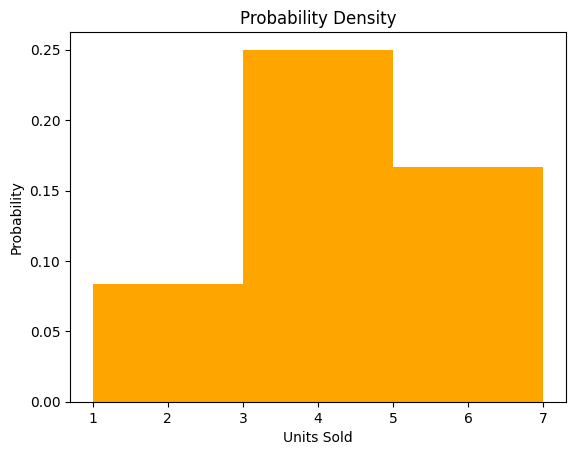

In [ ]:
# Creating a series
order_days = historical_full_df[(historical_full_df['account_id'] == user) & (historical_full_df['month_year'] >= '2022-02') & (historical_full_df['month_year'] <= '2022-07')]['order_days']

# Calculating the mean and variance
mean = np.mean(order_days)
variance = np.var(order_days, ddof=1) #ddof for sample!!!!!

# Plot
print(f"The mean of this user is: {mean}")
print(f"The variance of this user is: {variance}")
plt.hist(order_days, bins = 3, density = True, color = 'orange')
plt.xlabel('Units Sold')
plt.ylabel('Probability')
plt.title('Probability Density')
plt.show()

### 2b. Paramethers Estimation


**Estimation of the parameter/s of this function**

In order to estimate the parameters of this function (the **lambda**), and, since there is only on calculable paramether for this function, we could calculate the mean of order_days in a fixed period of time (e.g. past 6 months).

Let's calculate the lambda using Python.

In [ ]:
# Selecting the group of active users
active_users_df = historical_full_df[historical_full_df['account_id'] == user]

# Summing and grouping per month
active_monthly_order_days = active_users_df.groupby('month_year')['order_days'].sum()

# Lambda 
value_lambda = active_monthly_order_days.mean()

# Print
print(f" The lambda for the user {user} is {value_lambda.round(2)}.")

 The lambda for the user BR_07901723807 is 3.85.


The final equation would be:

$P(X = k) = \frac{3.85^k e^{-3.85}}{k!}$

### 2c. Probability Calculation of 4 Days of Order



The formula/density function, propose a simple way to calculate the probability of having more than 4 days of orders.

To calculate the probability of having more than 4 days of order, we need to use P(X > 4) (cumulative), so, we need to perform the summation of 0, 1, 2, 3 and 4 in order to find the probability NOT having orders we want. So, the remainning probability is what we want. In other words, we could:

$P(X > 4) = 1 - \sum_{k=0}^{4} \frac{\lambda^k e^{-\lambda}}{k!}$

NOTE: We need to subtract from 1 in order to find the rest of the probability. We're going to calculate the cumulative probability of having X from 0 to 4 and then subtract from 1 to find the result.

Let's check it in Python:

In [ ]:
# Lists
poisson_values = np.arange(0, 5)
results = []

# Loop
for k in poisson_values:
    pmf_value = (value_lambda ** k * np.exp(-value_lambda)) / math.factorial(k)
    results.append(pmf_value)

# Calculating the final probability
final_pmf = 1 - np.sum(results)

# Print
print(f"The probability of having more than 4 order days in a month is {final_pmf.round(4)}, or {final_pmf.round(4)*100}% for the user {user}.")

The probability of having more than 4 order days in a month is 0.3411, or 34.11% for the user BR_07901723807.


We could also do it directly using the statsmodels library.

In [426]:
# List
poisson_values = np.arange(0, 5)

# PMF
pmf_values = poisson.pmf(poisson_values, value_lambda)

# Final
final_pmf = 1 - np.sum(pmf_values)

# Print
print(f"The probability of having more than 4 order days in a month is {final_pmf.round(4)}, or {final_pmf.round(4)*100}% for the user {user}.")

The probability of having more than 4 order days in a month is 0.3411, or 34.11% for the user BR_07901723807.


### Time Between Days of Orders

**Estimation the time between days of orders by using formula that can estimate this time.**

In order to estimate the time between orders, we should use the exponential distribution that, for Poisson, is given by:

$\frac{1}{\lambda}$

Let's do it in Python:

In [ ]:
# Formula
exp_distribution = 1 / value_lambda

# Print
print(f" The mean time between order days if {exp_distribution} for the user {user}.")

 The mean time between order days if 0.26 for the user BR_07901723807.


According to the result above, the mean time between order days is 0.26 days **for this user.**